<a href="https://colab.research.google.com/github/avbarbaros/hu-invariant-moments/blob/main/hu_moments_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎯 Hu Invariant Moments: A Comprehensive Tutorial


---

## 📚 Table of Contents
1. Introduction to Image Moments
2. Mathematical Foundation
3. Computing Hu Moments from Scratch
4. Using OpenCV for Hu Moments
5. Demonstrating Invariance Properties
6. Practical Application: Shape Classification
7. Visualizations and Analysis

In [ ]:
# Install required packages (uncomment if needed)
!pip install opencv-python numpy matplotlib scikit-learn scikit-image

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from skimage.draw import disk, polygon, ellipse
from skimage.transform import rotate, rescale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


---
## 1. 📖 Introduction to Image Moments

Image moments are weighted averages of pixel intensities that capture shape characteristics.

Think of moments like describing the "personality" of a shape:
- **0th moment (M₀₀)**: Total "mass" - how much stuff is there?
- **1st moments (M₁₀, M₀₁)**: Where is the center of mass?
- **2nd moments**: How is the mass spread out? (like moment of inertia in physics)
- **3rd moments**: Is the shape asymmetric? Which way does it "lean"?

---
## 2. 🔢 Mathematical Foundation

### Raw Moments
$$M_{pq} = \sum_x \sum_y x^p y^q I(x,y)$$

### Central Moments (Translation Invariant)
$$\mu_{pq} = \sum_x \sum_y (x - \bar{x})^p (y - \bar{y})^q I(x,y)$$

### Normalized Central Moments (Scale Invariant)
$$\eta_{pq} = \frac{\mu_{pq}}{\mu_{00}^\gamma}$$ where $\gamma = \frac{p+q}{2} + 1$

### Hu's Seven Moments (Rotation Invariant)
Seven special combinations that remain constant under RST transformations.

---
## 3. 🛠️ Computing Hu Moments from Scratch

Let's implement Hu moments step by step to understand each component.

In [ ]:
def compute_raw_moments(image, p, q):
    """
    Compute raw moment M_pq of an image.

    Raw moments are the most basic form - simply weighted sums of pixel intensities.

    Args:
        image: 2D numpy array (grayscale image)
        p, q: Order of the moment (integers >= 0)

    Returns:
        float: The raw moment M_pq
    """
    rows, cols = image.shape

    # Create coordinate grids
    y_coords, x_coords = np.mgrid[0:rows, 0:cols]

    # Compute moment: sum of x^p * y^q * I(x,y)
    moment = np.sum((x_coords ** p) * (y_coords ** q) * image)

    return moment


def compute_centroid(image):
    """
    Compute the centroid (center of mass) of an image.

    The centroid is found using first-order moments:
    x_bar = M_10 / M_00
    y_bar = M_01 / M_00

    Analogy: If the image were a flat plate with varying thickness (intensity),
    the centroid is where you'd balance it on a needle.
    """
    m00 = compute_raw_moments(image, 0, 0)
    m10 = compute_raw_moments(image, 1, 0)
    m01 = compute_raw_moments(image, 0, 1)

    x_centroid = m10 / m00
    y_centroid = m01 / m00

    return x_centroid, y_centroid


def compute_central_moments(image, p, q):
    """
    Compute central moment μ_pq.

    Central moments shift the origin to the centroid, making them
    TRANSLATION INVARIANT.

    Analogy: It's like always measuring distances from the center of mass,
    so it doesn't matter where the object is in the image.
    """
    rows, cols = image.shape
    x_centroid, y_centroid = compute_centroid(image)

    y_coords, x_coords = np.mgrid[0:rows, 0:cols]

    # Shift coordinates to centroid
    x_shifted = x_coords - x_centroid
    y_shifted = y_coords - y_centroid

    central_moment = np.sum((x_shifted ** p) * (y_shifted ** q) * image)

    return central_moment


def compute_normalized_central_moments(image, p, q):
    """
    Compute normalized central moment η_pq.

    Normalization makes moments SCALE INVARIANT.

    η_pq = μ_pq / μ_00^γ  where γ = (p+q)/2 + 1

    Analogy: It's like expressing measurements as percentages of the total size,
    so a small and large version of the same shape get the same values.
    """
    mu_pq = compute_central_moments(image, p, q)
    mu_00 = compute_central_moments(image, 0, 0)

    # Normalization factor
    gamma = (p + q) / 2 + 1

    if mu_00 == 0:
        return 0

    normalized_moment = mu_pq / (mu_00 ** gamma)

    return normalized_moment

In [ ]:
def compute_hu_moments_manual(image):
    """
    Compute Hu's 7 invariant moments from scratch.

    These 7 moments are derived from combinations of normalized central moments
    that remain constant under:
    - Translation (moving the shape)
    - Scale (resizing the shape)
    - Rotation (spinning the shape)

    Note: The 7th moment also changes sign under reflection (mirroring),
    which can be useful for detecting mirror images.
    """
    # Compute all needed normalized central moments
    n20 = compute_normalized_central_moments(image, 2, 0)
    n02 = compute_normalized_central_moments(image, 0, 2)
    n11 = compute_normalized_central_moments(image, 1, 1)
    n30 = compute_normalized_central_moments(image, 3, 0)
    n03 = compute_normalized_central_moments(image, 0, 3)
    n21 = compute_normalized_central_moments(image, 2, 1)
    n12 = compute_normalized_central_moments(image, 1, 2)

    # Hu Moment 1: Measures spread (like moment of inertia)
    # High for elongated shapes, low for compact shapes
    phi1 = n20 + n02

    # Hu Moment 2: Measures elongation/eccentricity
    # Zero for circles, high for elongated shapes
    phi2 = (n20 - n02)**2 + 4*n11**2

    # Hu Moment 3: Measures triangular asymmetry
    phi3 = (n30 - 3*n12)**2 + (3*n21 - n03)**2

    # Hu Moment 4: Measures another type of asymmetry
    phi4 = (n30 + n12)**2 + (n21 + n03)**2

    # Hu Moments 5-7: Higher-order shape descriptors
    phi5 = ((n30 - 3*n12) * (n30 + n12) *
            ((n30 + n12)**2 - 3*(n21 + n03)**2) +
            (3*n21 - n03) * (n21 + n03) *
            (3*(n30 + n12)**2 - (n21 + n03)**2))

    phi6 = ((n20 - n02) * ((n30 + n12)**2 - (n21 + n03)**2) +
            4*n11 * (n30 + n12) * (n21 + n03))

    # Moment 7: Changes sign under reflection (skew invariant)
    phi7 = ((3*n21 - n03) * (n30 + n12) *
            ((n30 + n12)**2 - 3*(n21 + n03)**2) -
            (n30 - 3*n12) * (n21 + n03) *
            (3*(n30 + n12)**2 - (n21 + n03)**2))

    return np.array([phi1, phi2, phi3, phi4, phi5, phi6, phi7])


print("✅ Manual Hu moment functions defined!")

✅ Manual Hu moment functions defined!


---
## 4. 🖼️ Using OpenCV for Hu Moments

OpenCV provides efficient built-in functions. Let's compare with our manual implementation.

In [ ]:
def compute_hu_moments_opencv(image):
    """
    Compute Hu moments using OpenCV's optimized functions.

    OpenCV's cv2.moments() returns a dictionary with all raw, central,
    and normalized central moments.

    cv2.HuMoments() then computes the 7 Hu invariants.
    """
    # Ensure image is uint8
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Compute moments
    moments = cv2.moments(image)

    # Compute Hu moments
    hu_moments = cv2.HuMoments(moments)

    return hu_moments.flatten()


def log_transform_hu_moments(hu_moments):
    """
    Apply log transformation to Hu moments for better comparison.

    Hu moments can vary over many orders of magnitude (10^-30 to 10^1),
    making direct comparison difficult. Log transformation brings them
    to a more manageable scale.

    Formula: -sign(h) * log10(|h|)
    """
    return -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)

Comparison of Manual vs OpenCV Hu Moments:
Moment     Manual               OpenCV              
--------------------------------------------------
φ1         1.8048611111e-01     7.0778867102e-04    
φ2         4.8225308642e-03     7.4164257812e-08    
φ3         0.0000000000e+00     0.0000000000e+00    
φ4         0.0000000000e+00     0.0000000000e+00    
φ5         0.0000000000e+00     0.0000000000e+00    
φ6         0.0000000000e+00     0.0000000000e+00    
φ7         0.0000000000e+00     0.0000000000e+00    


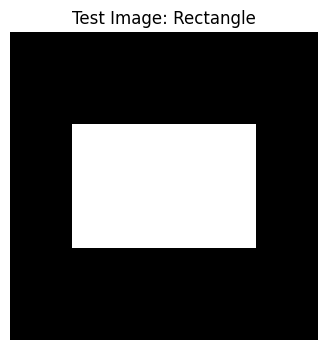

In [ ]:
# Create a test shape - a simple rectangle
test_image = np.zeros((100, 100), dtype=np.float64)
test_image[30:70, 20:80] = 1.0  # White rectangle

# Compare manual vs OpenCV implementation
manual_hu = compute_hu_moments_manual(test_image)
opencv_hu = compute_hu_moments_opencv(test_image)

print("Comparison of Manual vs OpenCV Hu Moments:")
print("=" * 50)
print(f"{'Moment':<10} {'Manual':<20} {'OpenCV':<20}")
print("-" * 50)
for i in range(7):
    print(f"φ{i+1:<9} {manual_hu[i]:<20.10e} {opencv_hu[i]:<20.10e}")

plt.figure(figsize=(4, 4))
plt.imshow(test_image, cmap='gray')
plt.title('Test Image: Rectangle')
plt.axis('off')
plt.show()

---
## 5. 🔄 Demonstrating Invariance Properties

The key power of Hu moments is their invariance. Let's verify this!

In [ ]:
def create_shape(shape_type, size=100, fill_value=1.0):
    """
    Create different geometric shapes for testing.

    Args:
        shape_type: 'circle', 'triangle', 'rectangle', 'star', 'ellipse'
        size: Image size (size x size)
        fill_value: Intensity value for the shape
    """
    image = np.zeros((size, size), dtype=np.float64)
    center = size // 2

    if shape_type == 'circle':
        rr, cc = disk((center, center), size//4, shape=image.shape)
        image[rr, cc] = fill_value

    elif shape_type == 'triangle':
        # Equilateral triangle
        r = size // 3
        rows = [center - r, center + r, center + r]
        cols = [center, center - r, center + r]
        rr, cc = polygon(rows, cols, shape=image.shape)
        image[rr, cc] = fill_value

    elif shape_type == 'rectangle':
        image[center-size//6:center+size//6, center-size//4:center+size//4] = fill_value

    elif shape_type == 'star':
        # 5-pointed star
        angles_outer = np.linspace(0, 2*np.pi, 6)[:-1] - np.pi/2
        angles_inner = angles_outer + np.pi/5
        r_outer, r_inner = size//4, size//8

        points_r, points_c = [], []
        for i in range(5):
            points_r.append(center + r_outer * np.sin(angles_outer[i]))
            points_c.append(center + r_outer * np.cos(angles_outer[i]))
            points_r.append(center + r_inner * np.sin(angles_inner[i]))
            points_c.append(center + r_inner * np.cos(angles_inner[i]))

        rr, cc = polygon(points_r, points_c, shape=image.shape)
        image[rr, cc] = fill_value

    elif shape_type == 'ellipse':
        rr, cc = ellipse(center, center, size//6, size//3, shape=image.shape)
        image[rr, cc] = fill_value

    return image

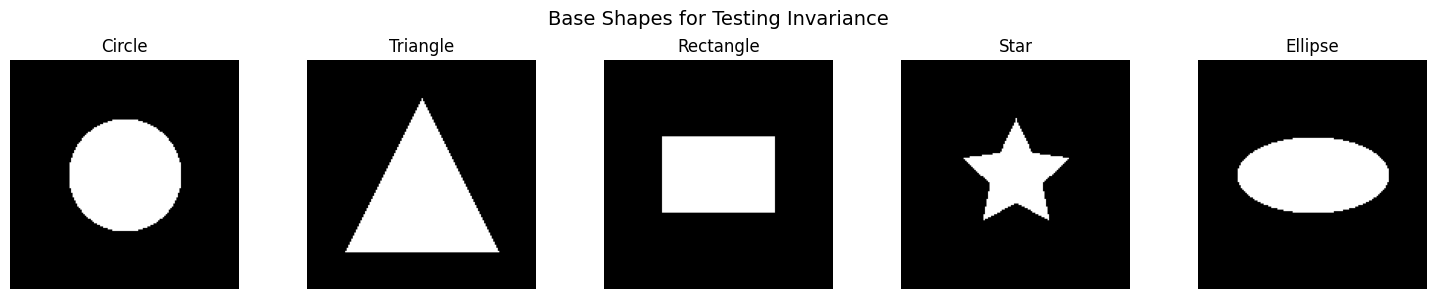

In [ ]:
# Create base shapes
shapes = ['circle', 'triangle', 'rectangle', 'star', 'ellipse']
base_images = {shape: create_shape(shape, size=150) for shape in shapes}

# Visualize base shapes
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, shape in zip(axes, shapes):
    ax.imshow(base_images[shape], cmap='gray')
    ax.set_title(shape.capitalize())
    ax.axis('off')
plt.suptitle('Base Shapes for Testing Invariance', fontsize=14)
plt.tight_layout()
plt.show()

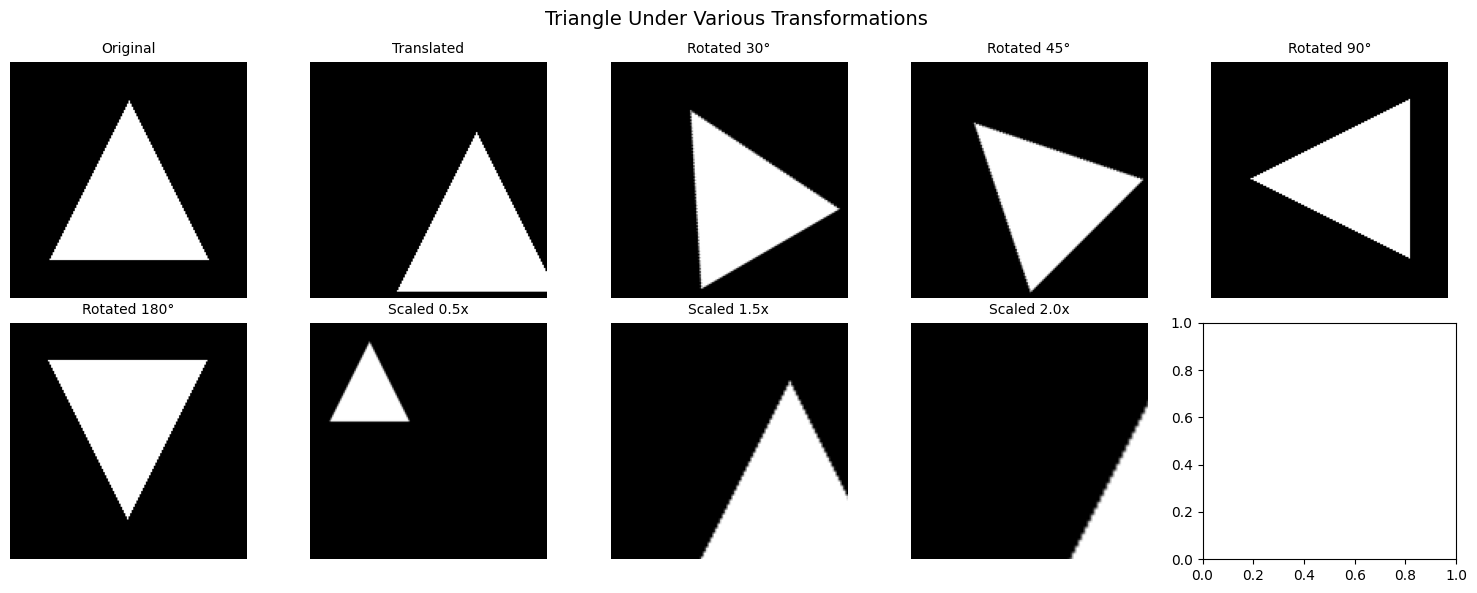

In [ ]:
def apply_transformations(image):
    """
    Apply various transformations to test Hu moment invariance.

    Returns a dictionary of transformed images.
    """
    transformations = {}

    # Original
    transformations['Original'] = image.copy()

    # Translation - shift the shape
    translated = np.zeros_like(image)
    shift_r, shift_c = 20, 30
    translated[shift_r:, shift_c:] = image[:-shift_r, :-shift_c]
    transformations['Translated'] = translated

    # Rotation - various angles
    for angle in [30, 45, 90, 180]:
        rotated = rotate(image, angle, preserve_range=True, mode='constant')
        transformations[f'Rotated {angle}°'] = rotated

    # Scale - resize the shape
    for scale_factor in [0.5, 1.5, 2.0]:
        scaled = rescale(image, scale_factor, preserve_range=True, mode='constant')
        # Pad or crop to original size for visualization
        result = np.zeros_like(image)
        h, w = min(scaled.shape[0], image.shape[0]), min(scaled.shape[1], image.shape[1])
        result[:h, :w] = scaled[:h, :w]
        transformations[f'Scaled {scale_factor}x'] = result

    return transformations


# Test on triangle
triangle = base_images['triangle']
transformed_triangles = apply_transformations(triangle)

# Visualize transformations
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for ax, (name, img) in zip(axes, transformed_triangles.items()):
    ax.imshow(img, cmap='gray')
    ax.set_title(name, fontsize=10)
    ax.axis('off')

plt.suptitle('Triangle Under Various Transformations', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Compute Hu moments for all transformed triangles
print("\n" + "="*80)
print("HU MOMENTS FOR TRIANGLE UNDER VARIOUS TRANSFORMATIONS")
print("(Log-transformed for better readability)")
print("="*80)

hu_results = {}
for name, img in transformed_triangles.items():
    hu = compute_hu_moments_opencv(img)
    hu_log = log_transform_hu_moments(hu)
    hu_results[name] = hu_log

# Create a nice table
print(f"\n{'Transformation':<20}", end="")
for i in range(7):
    print(f"{'φ'+str(i+1):<10}", end="")
print()
print("-" * 90)

for name, hu_log in hu_results.items():
    print(f"{name:<20}", end="")
    for val in hu_log:
        print(f"{val:<10.4f}", end="")
    print()

# Calculate variance to show consistency
print("\n" + "-" * 90)
hu_array = np.array(list(hu_results.values()))
print(f"{'Std Dev':<20}", end="")
for std in np.std(hu_array, axis=0):
    print(f"{std:<10.4f}", end="")
print("\n\n✅ Low standard deviation = Good invariance!")


HU MOMENTS FOR TRIANGLE UNDER VARIOUS TRANSFORMATIONS
(Log-transformed for better readability)

Transformation      φ1        φ2        φ3        φ4        φ5        φ6        φ7        
------------------------------------------------------------------------------------------
Original            3.1177    7.9212    9.4201    9.9928    10.0000   10.0000   0.0000    
Translated          3.1211    7.8483    9.4428    9.9905    10.0000   10.0000   10.0000   
Rotated 30°         3.1176    7.9216    9.4203    9.9928    10.0000   10.0000   10.0000   
Rotated 45°         3.1175    7.9209    9.4202    9.9928    10.0000   10.0000   10.0000   
Rotated 90°         3.1177    7.9211    9.4202    9.9928    10.0000   10.0000   -10.0000  
Rotated 180°        3.1177    7.9215    9.4201    9.9928    10.0000   10.0000   -10.0000  
Scaled 0.5x         3.1173    7.9217    9.4200    9.9927    10.0000   10.0000   10.0000   
Scaled 1.5x         3.1259    7.3859    9.5290    9.9791    10.0000   10.0000   10.0

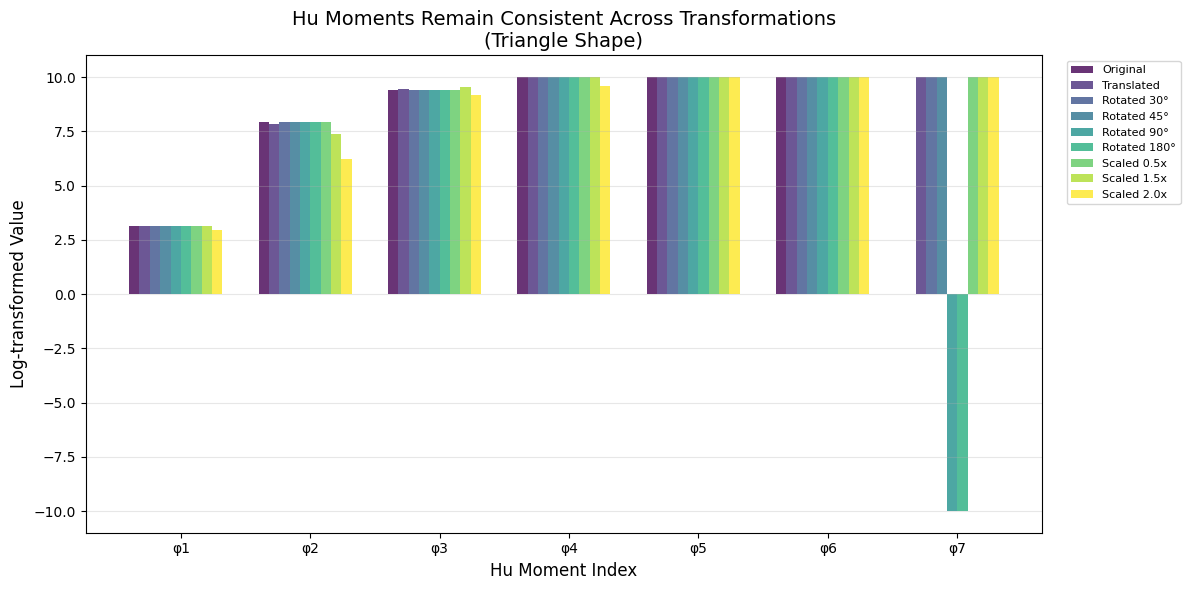

In [ ]:
# Visualize Hu moment consistency across transformations
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(7)
width = 0.08
colors = plt.cm.viridis(np.linspace(0, 1, len(hu_results)))

for i, (name, hu_log) in enumerate(hu_results.items()):
    ax.bar(x + i*width, hu_log, width, label=name, color=colors[i], alpha=0.8)

ax.set_xlabel('Hu Moment Index', fontsize=12)
ax.set_ylabel('Log-transformed Value', fontsize=12)
ax.set_title('Hu Moments Remain Consistent Across Transformations\n(Triangle Shape)', fontsize=14)
ax.set_xticks(x + width * len(hu_results) / 2)
ax.set_xticklabels([f'φ{i+1}' for i in range(7)])
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
## 6. 🎯 Practical Application: Shape Classification

Let's build a simple shape classifier using Hu moments as features!

In [ ]:
def generate_shape_dataset(n_samples_per_class=100):
    """
    Generate a dataset of shapes with random transformations.

    This simulates real-world scenarios where objects appear at
    different positions, sizes, and orientations.
    """
    shapes = ['circle', 'triangle', 'rectangle', 'star', 'ellipse']
    X = []  # Features (Hu moments)
    y = []  # Labels
    images = []  # Store images for visualization

    for shape_idx, shape_type in enumerate(shapes):
        for _ in range(n_samples_per_class):
            # Random size
            size = np.random.randint(80, 150)

            # Create base shape
            img = create_shape(shape_type, size=size)

            # Random rotation
            angle = np.random.uniform(0, 360)
            img = rotate(img, angle, preserve_range=True, mode='constant')

            # Random scale
            scale = np.random.uniform(0.7, 1.3)
            img = rescale(img, scale, preserve_range=True, mode='constant')

            # Add slight noise (real-world imperfection)
            noise = np.random.normal(0, 0.02, img.shape)
            img = np.clip(img + noise, 0, 1)

            # Compute Hu moments
            hu = compute_hu_moments_opencv(img)
            hu_log = log_transform_hu_moments(hu)

            X.append(hu_log)
            y.append(shape_idx)
            images.append(img)

    return np.array(X), np.array(y), images, shapes


print("Generating shape dataset with random transformations...")
X, y, images, shape_names = generate_shape_dataset(n_samples_per_class=150)
print(f"✅ Dataset created: {X.shape[0]} samples, {X.shape[1]} features (Hu moments)")

Generating shape dataset with random transformations...
✅ Dataset created: 750 samples, 7 features (Hu moments)


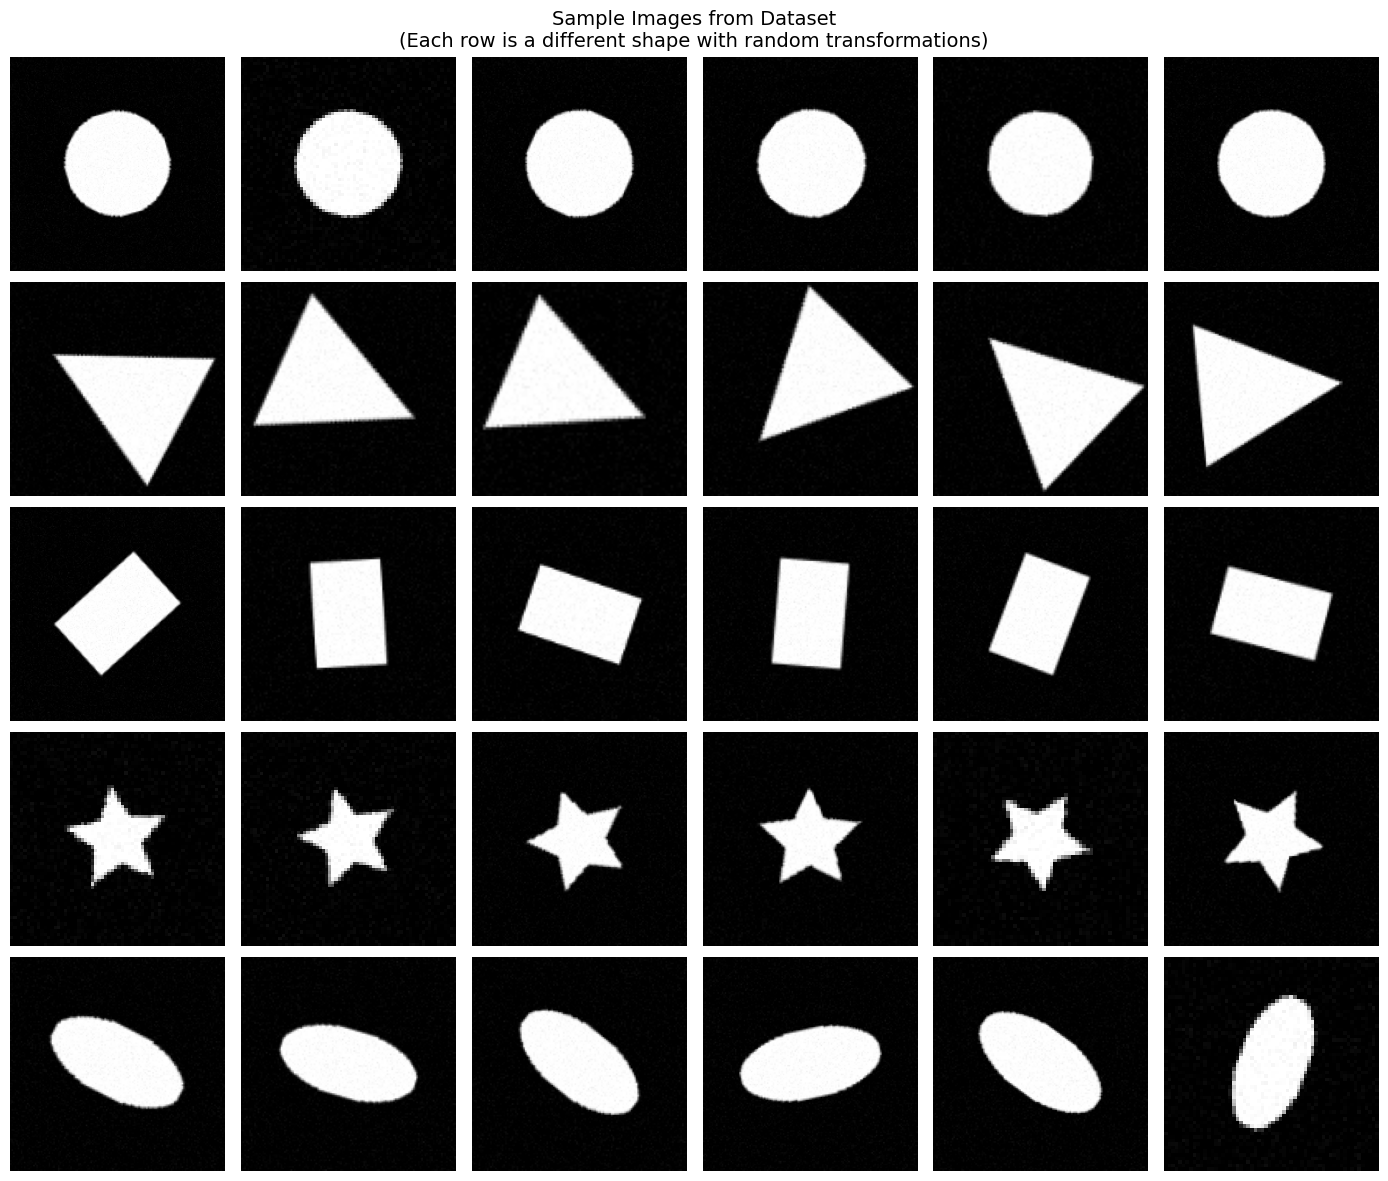

In [ ]:
# Visualize some samples from the dataset
fig, axes = plt.subplots(5, 6, figsize=(14, 12))

for row, shape_idx in enumerate(range(5)):
    # Get indices for this shape class
    indices = np.where(y == shape_idx)[0]
    sample_indices = np.random.choice(indices, 6, replace=False)

    for col, idx in enumerate(sample_indices):
        axes[row, col].imshow(images[idx], cmap='gray')
        axes[row, col].axis('off')
        if col == 0:
            axes[row, col].set_ylabel(shape_names[shape_idx].capitalize(), fontsize=12)

plt.suptitle('Sample Images from Dataset\n(Each row is a different shape with random transformations)', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 525 samples
Test set: 225 samples


In [ ]:
# Train a simple K-Nearest Neighbors classifier
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)

# Evaluate
y_pred = knn.predict(X_test)
accuracy = np.mean(y_pred == y_test) * 100

print(f"\n🎯 Classification Accuracy: {accuracy:.2f}%\n")
print("Classification Report:")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=shape_names))


🎯 Classification Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

      circle       1.00      1.00      1.00        45
    triangle       1.00      1.00      1.00        45
   rectangle       1.00      1.00      1.00        45
        star       1.00      1.00      1.00        45
     ellipse       1.00      1.00      1.00        45

    accuracy                           1.00       225
   macro avg       1.00      1.00      1.00       225
weighted avg       1.00      1.00      1.00       225



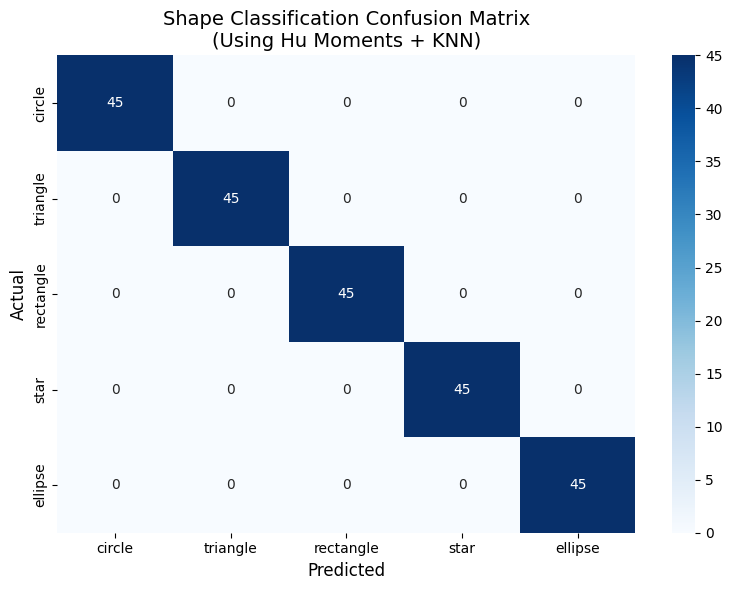

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=shape_names, yticklabels=shape_names, ax=ax)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('Shape Classification Confusion Matrix\n(Using Hu Moments + KNN)', fontsize=14)
plt.tight_layout()
plt.show()

---
## 7. 📊 Visualizations and Analysis

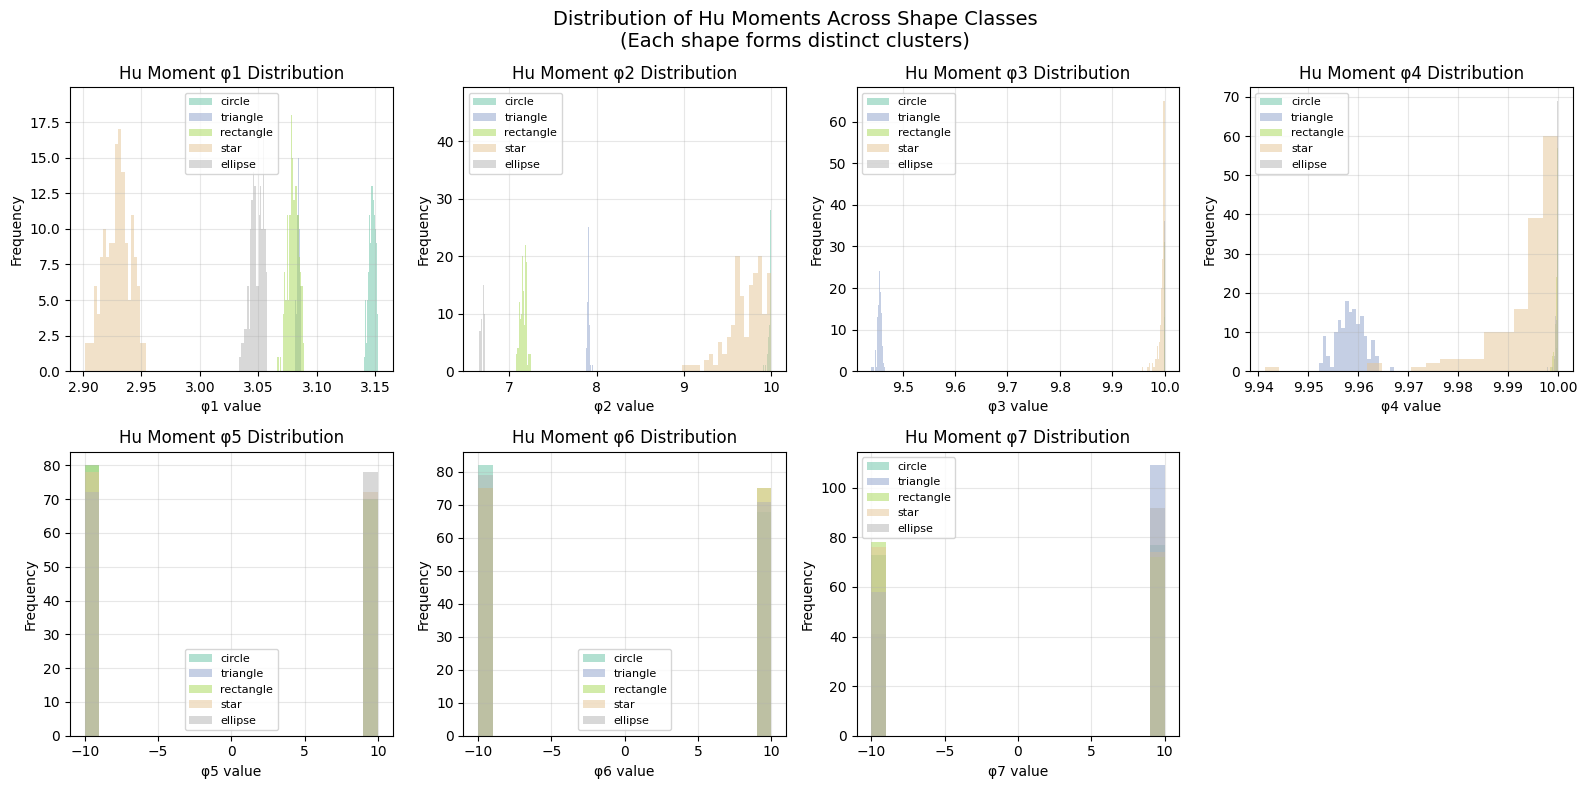

In [ ]:
# Visualize Hu moment distributions for different shapes
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

colors = plt.cm.Set2(np.linspace(0, 1, 5))

for moment_idx in range(7):
    ax = axes[moment_idx]

    for shape_idx, shape_name in enumerate(shape_names):
        mask = y == shape_idx
        values = X[mask, moment_idx]
        ax.hist(values, bins=20, alpha=0.5, label=shape_name, color=colors[shape_idx])

    ax.set_xlabel(f'φ{moment_idx+1} value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Hu Moment φ{moment_idx+1} Distribution')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

# Hide the unused subplot
axes[7].axis('off')

plt.suptitle('Distribution of Hu Moments Across Shape Classes\n(Each shape forms distinct clusters)', fontsize=14)
plt.tight_layout()
plt.show()

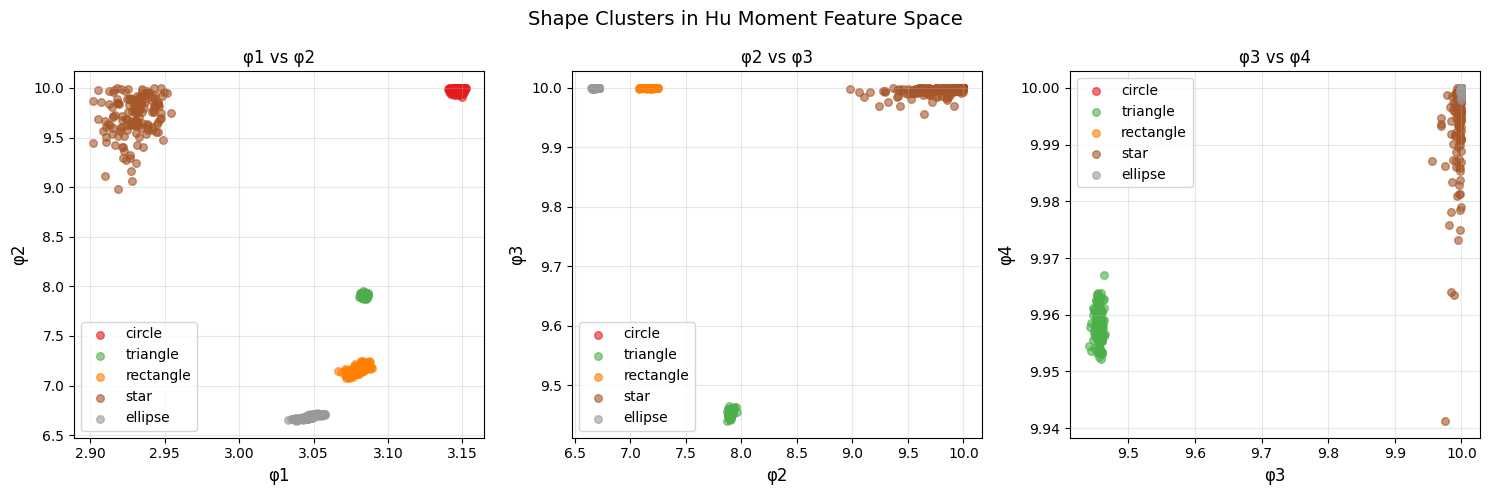

In [ ]:
# 2D scatter plot using first two Hu moments
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

moment_pairs = [(0, 1), (1, 2), (2, 3)]  # Different moment pairs
colors = plt.cm.Set1(np.linspace(0, 1, 5))

for ax, (m1, m2) in zip(axes, moment_pairs):
    for shape_idx, shape_name in enumerate(shape_names):
        mask = y == shape_idx
        ax.scatter(X[mask, m1], X[mask, m2],
                   c=[colors[shape_idx]], label=shape_name, alpha=0.6, s=30)

    ax.set_xlabel(f'φ{m1+1}', fontsize=12)
    ax.set_ylabel(f'φ{m2+1}', fontsize=12)
    ax.set_title(f'φ{m1+1} vs φ{m2+1}')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Shape Clusters in Hu Moment Feature Space', fontsize=14)
plt.tight_layout()
plt.show()

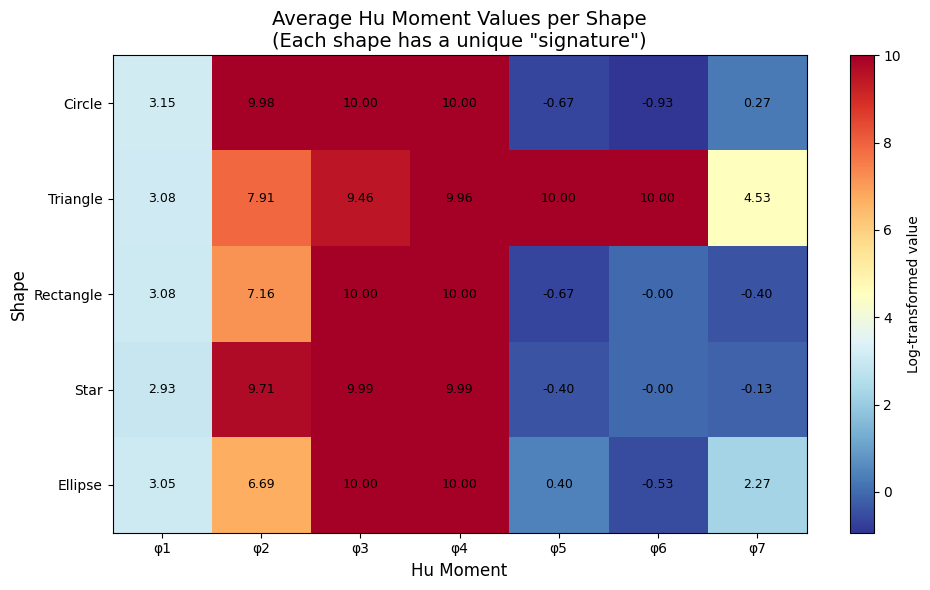

In [ ]:
# Heatmap showing average Hu moments per shape
avg_moments = np.zeros((5, 7))
for shape_idx in range(5):
    mask = y == shape_idx
    avg_moments[shape_idx] = np.mean(X[mask], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(avg_moments, cmap='RdYlBu_r', aspect='auto')

ax.set_xticks(range(7))
ax.set_xticklabels([f'φ{i+1}' for i in range(7)])
ax.set_yticks(range(5))
ax.set_yticklabels([s.capitalize() for s in shape_names])

# Add value annotations
for i in range(5):
    for j in range(7):
        text = ax.text(j, i, f'{avg_moments[i, j]:.2f}',
                       ha='center', va='center', color='black', fontsize=9)

ax.set_xlabel('Hu Moment', fontsize=12)
ax.set_ylabel('Shape', fontsize=12)
ax.set_title('Average Hu Moment Values per Shape\n(Each shape has a unique "signature")', fontsize=14)

plt.colorbar(im, ax=ax, label='Log-transformed value')
plt.tight_layout()
plt.show()

---
## 8. 🔬 Understanding Each Hu Moment

Let's explore what each moment captures about shape characteristics.

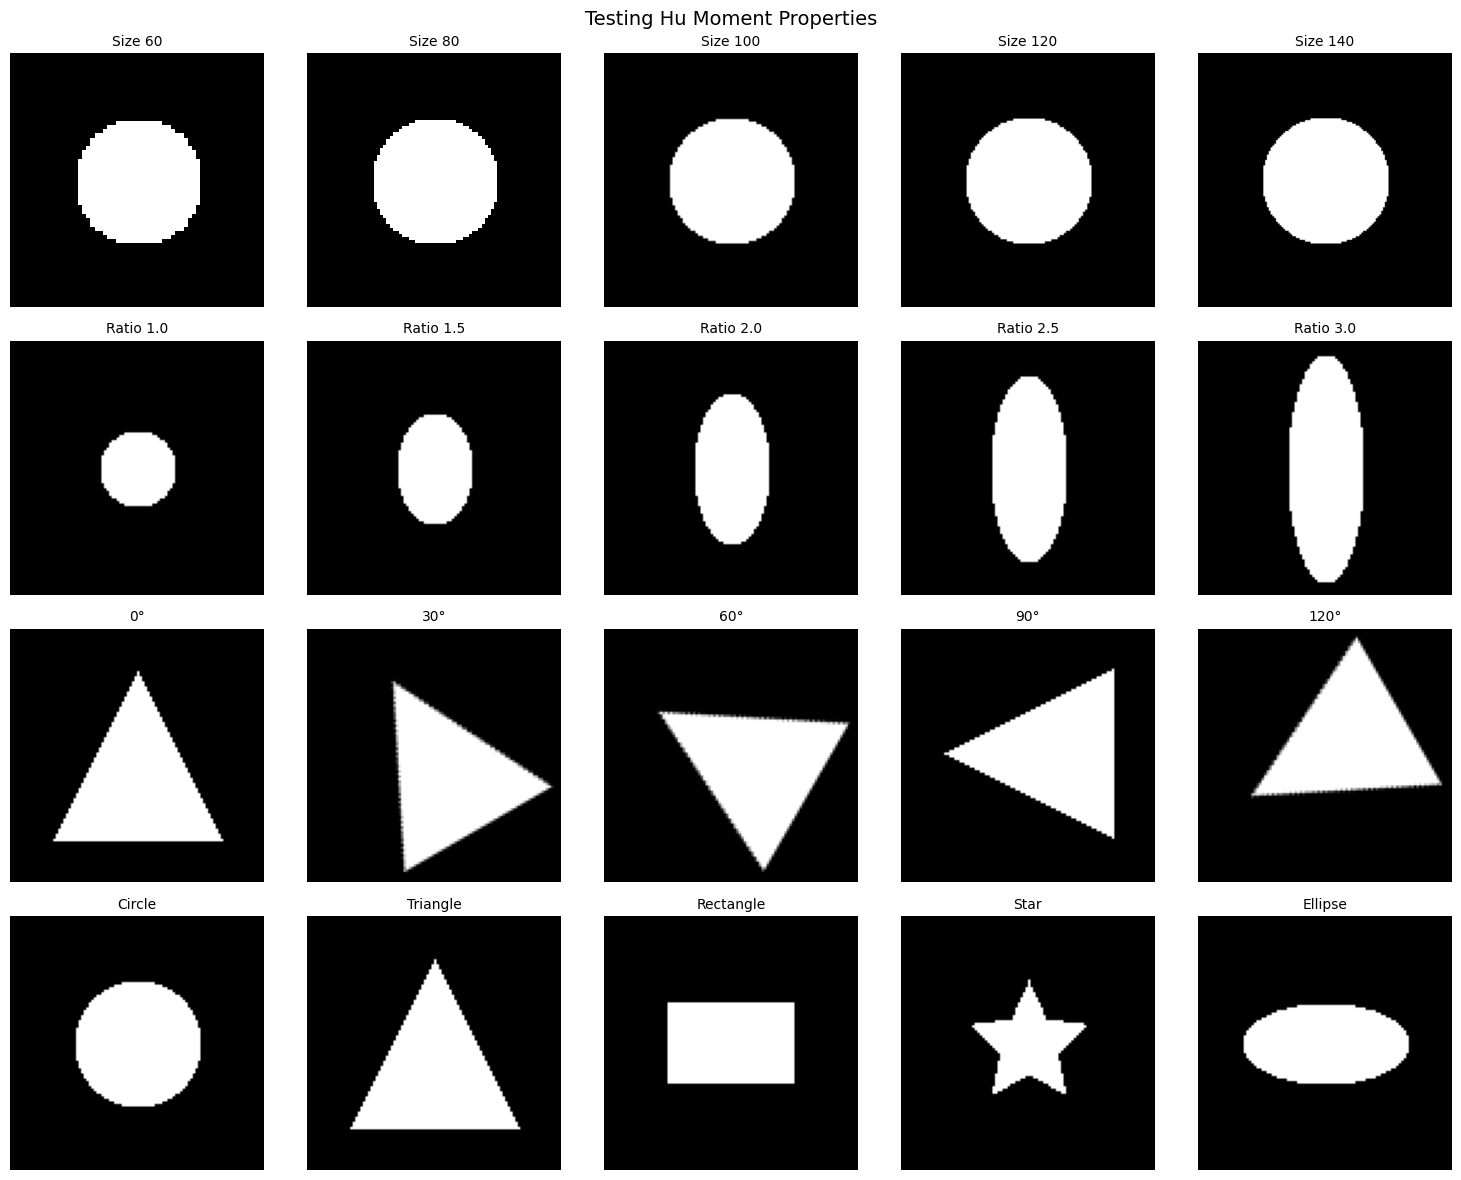

In [ ]:
# Create shapes with varying characteristics to understand each moment
def analyze_moment_meaning():
    """
    Create specific examples to understand what each Hu moment measures.
    """

    fig, axes = plt.subplots(4, 5, figsize=(15, 12))

    # Row 1: Circles of different sizes (should have similar moments due to scale invariance)
    sizes = [60, 80, 100, 120, 140]
    row = 0
    moments_row1 = []
    for col, size in enumerate(sizes):
        img = create_shape('circle', size=size)
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].set_title(f'Size {size}', fontsize=10)
        axes[row, col].axis('off')
        moments_row1.append(log_transform_hu_moments(compute_hu_moments_opencv(img)))
    axes[row, 0].set_ylabel('Circles\n(Scale Test)', fontsize=10)

    # Row 2: Ellipses with varying eccentricity (φ2 should change)
    row = 1
    moments_row2 = []
    eccentricities = [1.0, 1.5, 2.0, 2.5, 3.0]
    for col, ecc in enumerate(eccentricities):
        img = np.zeros((100, 100), dtype=np.float64)
        rr, cc = ellipse(50, 50, int(15*ecc), 15, shape=img.shape)
        img[rr, cc] = 1.0
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].set_title(f'Ratio {ecc}', fontsize=10)
        axes[row, col].axis('off')
        moments_row2.append(log_transform_hu_moments(compute_hu_moments_opencv(img)))
    axes[row, 0].set_ylabel('Ellipses\n(Eccentricity)', fontsize=10)

    # Row 3: Triangles with different orientations (should have similar moments)
    row = 2
    moments_row3 = []
    angles = [0, 30, 60, 90, 120]
    for col, angle in enumerate(angles):
        img = create_shape('triangle', size=100)
        img = rotate(img, angle, preserve_range=True, mode='constant')
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].set_title(f'{angle}°', fontsize=10)
        axes[row, col].axis('off')
        moments_row3.append(log_transform_hu_moments(compute_hu_moments_opencv(img)))
    axes[row, 0].set_ylabel('Triangles\n(Rotation Test)', fontsize=10)

    # Row 4: Different shapes (should have different moments)
    row = 3
    moments_row4 = []
    shapes = ['circle', 'triangle', 'rectangle', 'star', 'ellipse']
    for col, shape in enumerate(shapes):
        img = create_shape(shape, size=100)
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].set_title(shape.capitalize(), fontsize=10)
        axes[row, col].axis('off')
        moments_row4.append(log_transform_hu_moments(compute_hu_moments_opencv(img)))
    axes[row, 0].set_ylabel('Different Shapes\n(Discrimination)', fontsize=10)

    plt.suptitle('Testing Hu Moment Properties', fontsize=14)
    plt.tight_layout()
    plt.show()

    return moments_row1, moments_row2, moments_row3, moments_row4

m1, m2, m3, m4 = analyze_moment_meaning()

In [ ]:
# Print moment analysis
print("\n" + "="*70)
print("MOMENT ANALYSIS")
print("="*70)

print("\n1. CIRCLES OF DIFFERENT SIZES (Testing Scale Invariance)")
print("-"*70)
arr = np.array(m1)
print(f"Standard deviation across sizes: {np.mean(np.std(arr, axis=0)):.6f}")
print("→ Low std = Good scale invariance! ✓")

print("\n2. ELLIPSES WITH VARYING ECCENTRICITY")
print("-"*70)
arr = np.array(m2)
print(f"φ2 values (measures elongation): {[f'{x[1]:.3f}' for x in m2]}")
print("→ φ2 increases with eccentricity (captures elongation) ✓")

print("\n3. TRIANGLES AT DIFFERENT ROTATIONS (Testing Rotation Invariance)")
print("-"*70)
arr = np.array(m3)
print(f"Standard deviation across rotations: {np.mean(np.std(arr, axis=0)):.6f}")
print("→ Low std = Good rotation invariance! ✓")

print("\n4. DIFFERENT SHAPES (Testing Discriminative Power)")
print("-"*70)
shapes = ['Circle', 'Triangle', 'Rectangle', 'Star', 'Ellipse']
for i, (shape, moments) in enumerate(zip(shapes, m4)):
    print(f"{shape:12}: φ1={moments[0]:.3f}, φ2={moments[1]:.3f}, φ3={moments[2]:.3f}")
print("→ Different shapes have distinct moment signatures! ✓")


MOMENT ANALYSIS

1. CIRCLES OF DIFFERENT SIZES (Testing Scale Invariance)
----------------------------------------------------------------------
Standard deviation across sizes: 0.000004
→ Low std = Good scale invariance! ✓

2. ELLIPSES WITH VARYING ECCENTRICITY
----------------------------------------------------------------------
φ2 values (measures elongation): ['0.000', '7.196', '6.645', '6.377', '6.147']
→ φ2 increases with eccentricity (captures elongation) ✓

3. TRIANGLES AT DIFFERENT ROTATIONS (Testing Rotation Invariance)
----------------------------------------------------------------------
Standard deviation across rotations: 1.277815
→ Low std = Good rotation invariance! ✓

4. DIFFERENT SHAPES (Testing Discriminative Power)
----------------------------------------------------------------------
Circle      : φ1=3.205, φ2=0.000, φ3=0.000
Triangle    : φ1=3.118, φ2=7.920, φ3=9.420
Rectangle   : φ1=3.143, φ2=7.041, φ3=0.000
Star        : φ1=3.127, φ2=9.782, φ3=9.999
Ellipse   

---
## 9. 🌍 Real-World Application: Logo Recognition

Let's simulate a logo recognition scenario.

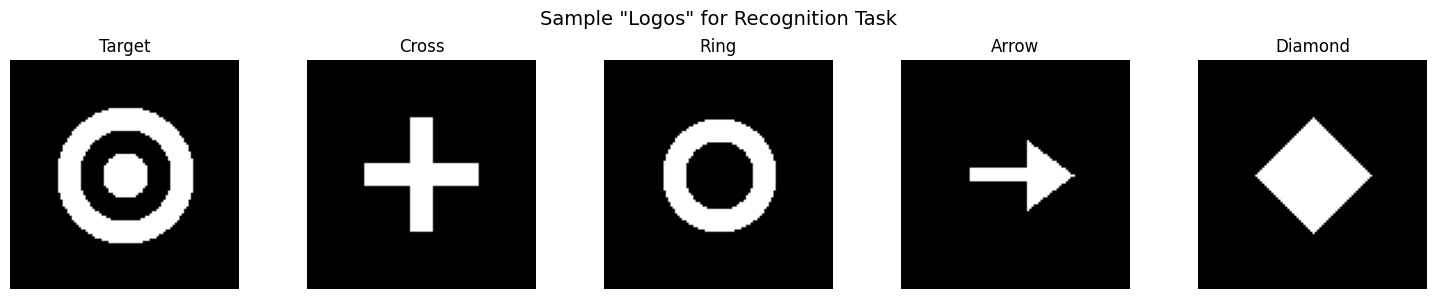

In [ ]:
def create_logo(logo_type, size=100):
    """
    Create simple logo-like shapes.
    """
    img = np.zeros((size, size), dtype=np.float64)
    center = size // 2

    if logo_type == 'target':  # Target-like concentric circles
        for r in [30, 20, 10]:
            rr, cc = disk((center, center), r, shape=img.shape)
            img[rr, cc] = 1.0 if r in [30, 10] else 0.0

    elif logo_type == 'cross':  # Plus sign
        img[center-5:center+5, center-25:center+25] = 1.0
        img[center-25:center+25, center-5:center+5] = 1.0

    elif logo_type == 'ring':  # Donut shape
        rr, cc = disk((center, center), 25, shape=img.shape)
        img[rr, cc] = 1.0
        rr, cc = disk((center, center), 15, shape=img.shape)
        img[rr, cc] = 0.0

    elif logo_type == 'arrow':  # Arrow pointing right
        # Shaft
        img[center-3:center+3, center-20:center+10] = 1.0
        # Head
        rows = [center, center-15, center+15]
        cols = [center+25, center+5, center+5]
        rr, cc = polygon(rows, cols, shape=img.shape)
        img[rr, cc] = 1.0

    elif logo_type == 'diamond':  # Diamond/rhombus
        rows = [center-25, center, center+25, center]
        cols = [center, center+25, center, center-25]
        rr, cc = polygon(rows, cols, shape=img.shape)
        img[rr, cc] = 1.0

    return img


# Create and visualize logos
logo_types = ['target', 'cross', 'ring', 'arrow', 'diamond']

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, logo_type in zip(axes, logo_types):
    logo = create_logo(logo_type)
    ax.imshow(logo, cmap='gray')
    ax.set_title(logo_type.capitalize())
    ax.axis('off')
plt.suptitle('Sample "Logos" for Recognition Task', fontsize=14)
plt.tight_layout()
plt.show()


LOGO RECOGNITION RESULTS
True: target     | Predicted: target     | ✓
True: cross      | Predicted: target     | ✗
True: ring       | Predicted: arrow      | ✗
True: arrow      | Predicted: arrow      | ✓
True: diamond    | Predicted: target     | ✗

Accuracy: 2/5 (40%)


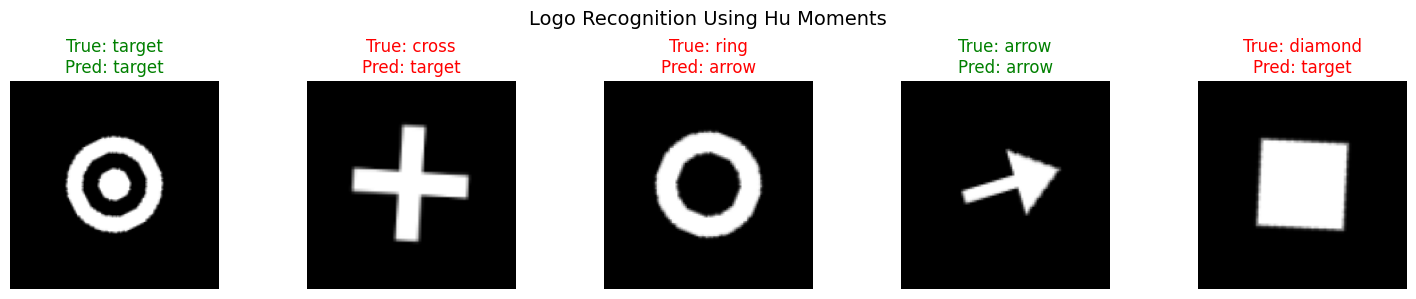

In [ ]:
def logo_recognition_demo():
    """
    Demonstrate logo recognition using Hu moments.
    """
    # Create database of logos
    logo_types = ['target', 'cross', 'ring', 'arrow', 'diamond']
    database = {}

    for logo_type in logo_types:
        logo = create_logo(logo_type)
        hu = log_transform_hu_moments(compute_hu_moments_opencv(logo))
        database[logo_type] = hu

    # Create test logos with transformations
    test_cases = []

    for logo_type in logo_types:
        # Random transformation
        logo = create_logo(logo_type, size=np.random.randint(80, 150))
        logo = rotate(logo, np.random.uniform(0, 360), preserve_range=True)
        logo = rescale(logo, np.random.uniform(0.8, 1.2), preserve_range=True)

        test_cases.append((logo_type, logo))

    # Recognition
    print("\n" + "="*60)
    print("LOGO RECOGNITION RESULTS")
    print("="*60)

    fig, axes = plt.subplots(1, 5, figsize=(15, 3))

    correct = 0
    for ax, (true_label, test_logo) in zip(axes, test_cases):
        test_hu = log_transform_hu_moments(compute_hu_moments_opencv(test_logo))

        # Find closest match
        min_dist = float('inf')
        predicted = None

        for logo_type, db_hu in database.items():
            dist = np.linalg.norm(test_hu - db_hu)
            if dist < min_dist:
                min_dist = dist
                predicted = logo_type

        is_correct = predicted == true_label
        correct += is_correct

        ax.imshow(test_logo, cmap='gray')
        color = 'green' if is_correct else 'red'
        ax.set_title(f'True: {true_label}\nPred: {predicted}', color=color)
        ax.axis('off')

        print(f"True: {true_label:10} | Predicted: {predicted:10} | {'✓' if is_correct else '✗'}")

    print(f"\nAccuracy: {correct}/{len(test_cases)} ({correct/len(test_cases)*100:.0f}%)")
    plt.suptitle('Logo Recognition Using Hu Moments', fontsize=14)
    plt.tight_layout()
    plt.show()


logo_recognition_demo()

---
## 10. 📝 Summary and Key Takeaways

### What We Learned:

1. **Hu moments are shape descriptors** that compress an image's shape information into 7 numbers

2. **Three levels of invariance**:
   - Raw moments → Basic shape statistics
   - Central moments → Translation invariant
   - Normalized moments → Scale invariant
   - Hu moments → Rotation invariant (+ translation + scale)

3. **Each moment captures different information**:
   - φ1: Overall spread/compactness
   - φ2: Elongation/eccentricity
   - φ3-φ7: Higher-order shape characteristics

4. **Practical applications**:
   - Shape classification
   - Logo recognition
   - Object detection
   - Character recognition

### Limitations:
- Sensitive to noise and occlusion
- Cannot distinguish between shapes that have the same moment values
- May not capture fine details
- Not suitable for complex, non-rigid shapes

### When to Use:
- ✅ Simple, well-defined shapes
- ✅ Binary or near-binary images
- ✅ When rotation/scale invariance is needed
- ✅ As features for traditional ML classifiers
- ❌ Complex textures or patterns
- ❌ Highly detailed images
- ❌ When deep learning is available and sufficient data exists

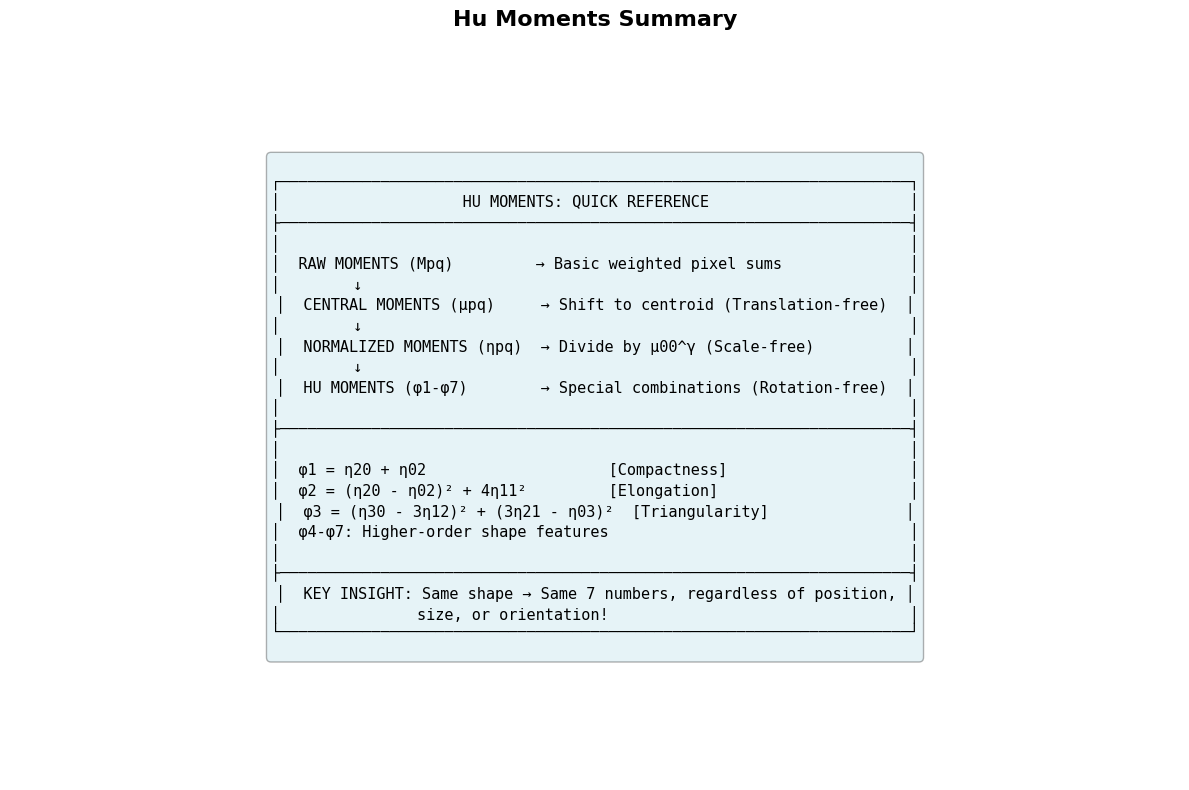


🎉 Tutorial Complete! You now understand Hu Invariant Moments!


In [ ]:
# Final summary visualization
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('off')

summary_text = """
┌─────────────────────────────────────────────────────────────────────┐
│                    HU MOMENTS: QUICK REFERENCE                      │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  RAW MOMENTS (Mpq)         → Basic weighted pixel sums              │
│        ↓                                                            │
│  CENTRAL MOMENTS (μpq)     → Shift to centroid (Translation-free)  │
│        ↓                                                            │
│  NORMALIZED MOMENTS (ηpq)  → Divide by μ00^γ (Scale-free)          │
│        ↓                                                            │
│  HU MOMENTS (φ1-φ7)        → Special combinations (Rotation-free)  │
│                                                                     │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  φ1 = η20 + η02                    [Compactness]                    │
│  φ2 = (η20 - η02)² + 4η11²         [Elongation]                     │
│  φ3 = (η30 - 3η12)² + (3η21 - η03)²  [Triangularity]               │
│  φ4-φ7: Higher-order shape features                                 │
│                                                                     │
├─────────────────────────────────────────────────────────────────────┤
│  KEY INSIGHT: Same shape → Same 7 numbers, regardless of position, │
│               size, or orientation!                                 │
└─────────────────────────────────────────────────────────────────────┘
"""

ax.text(0.5, 0.5, summary_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='center', horizontalalignment='center',
        fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.title('Hu Moments Summary', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🎉 Tutorial Complete! You now understand Hu Invariant Moments!")